<font size=7> Latencies Analysis

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist
from human_hip.animate import animate_latencies

In [2]:
with open("/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl", "rb") as filename:
    sd = pickle.load(filename)

<font color="red"> We save curated latency pairs because above calculation took over 1 minute

In [3]:
# good_pairs = curate_latencies(sd)
# with open( 'curate_latencies_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
# load pickled data
with open( 'curate_latencies_good_pairs.pkl' , 'rb') as my_file:
    good_pairs = pickle.load(my_file)

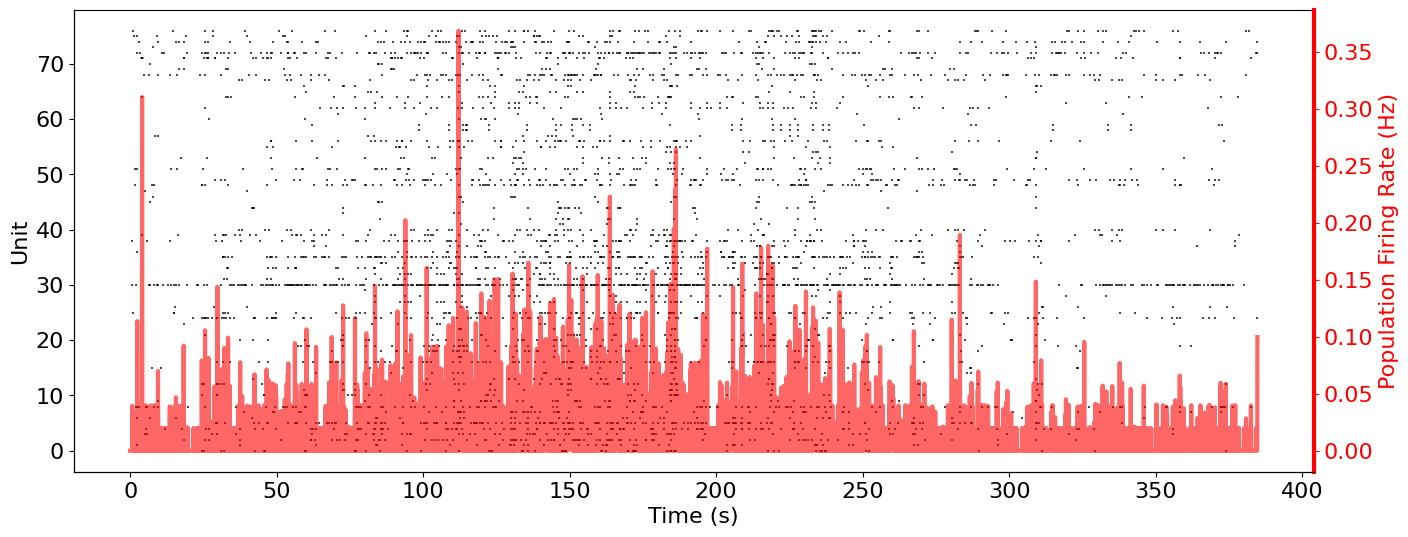

In [4]:
plot_raster_latency_pairs( sd, good_pairs )

372 um -- average pair distance
375 um -- average latency distance


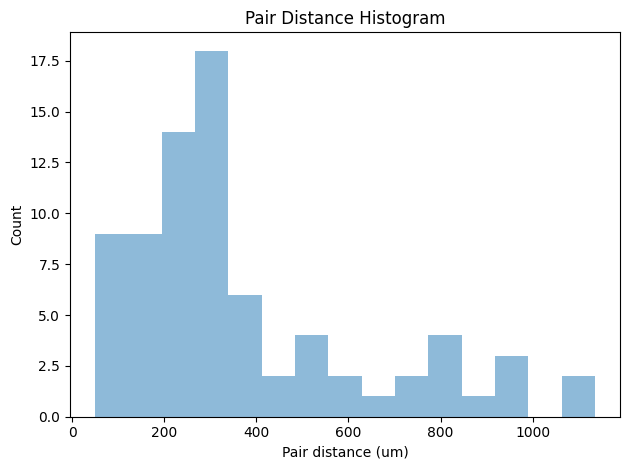

In [5]:
plot_latency_dist_hist(sd, good_pairs)

/tmp/ipykernel_24610/3965929820.py:14: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


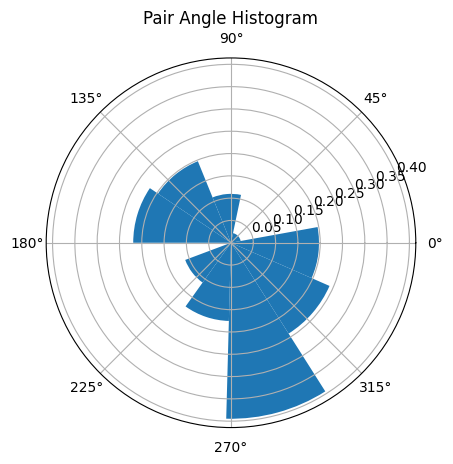

In [7]:
plot_latency_angle_hist(sd, good_pairs)

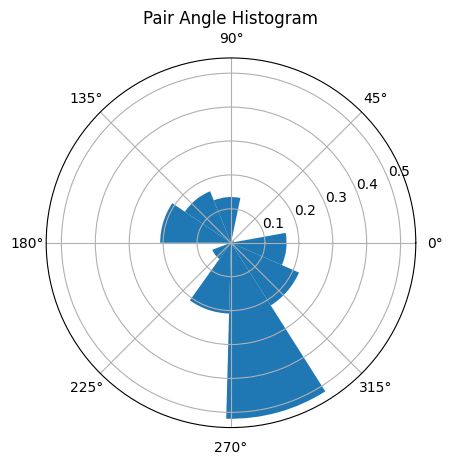

In [5]:
plot_latency_angle_hist(sd, good_pairs, by_firing_rate=True)

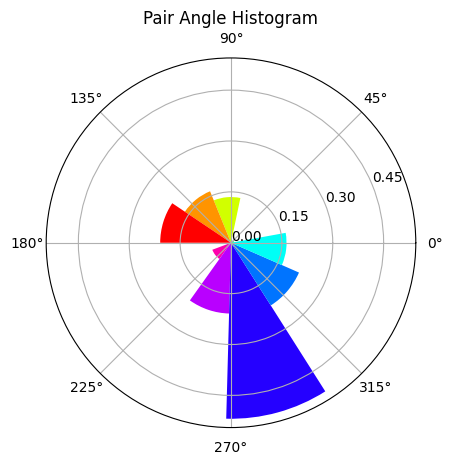

In [5]:
plot_latency_angle_hist(sd, good_pairs, by_firing_rate=True)

In [27]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact_manual

from matplotlib.ticker import MaxNLocator

import math


def plot_latency_angle_hist( sd, pairs, by_firing_rate=False, late_cutoff_low=1, late_cutoff_high=15):
    """
    Inputs:
        sd: SpikeData object
        pairs: np.array of neuron indices (as pairs) for which a connection exists, ex: [[0,1], [0,2], [2,3]]
        by_firing_rate: boolean, if True, the angle histogram will be weighted by the number of latencies for each pair
        late_cutoff_low: integer, the lower bound of the latency cutoff
        late_cutoff_high: integer, the upper bound of the latency cutoff
    Outputs:
        A plot depicting the histogram of the angles of the pairs
    """
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # make pairs point in same direction
    pairs = pairs                         # make a copy of pairs, this avoids some bug
    for i in range(len(pairs)):
        lag = np.median(latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20))
        if lag<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    # Creat arrows show angle of information flow from a neuron
    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    angle = np.arctan2(-(ends[:,1]-starts[:,1]), ends[:,0]-starts[:,0]) * -1

    if by_firing_rate:
        latency_counts = []
        for pair in pairs:
            latency_counts.append( len(latency_times( pair[0], pair[1], sd, ms_cutoff_low=late_cutoff_low, ms_cutoff_high=late_cutoff_high, positive_only=True )) )
        latency_counts= np.array(latency_counts)
        angle = np.repeat( angle, latency_counts )

    #n_bins = 30  # You can adjust the number of bins here
    counts, bin_edges = np.histogram(angle,  density=True)  #bins=n_bins,
    bin_width = np.diff(bin_edges)
    cmap = cm.get_cmap('hsv')

    

    bin_angles= (bin_edges[:-1] - bin_edges.min()) / (bin_edges.max() - bin_edges.min())
    bin_angles = bin_angles[::-1] 
    print(bin_angles)
    bin_angles
    # Calculate the color for each bin based on its edge angle
    bin_colors = cmap(bin_angles)

    
    ax = plt.subplot(111, polar=True)
    for idx, count in enumerate(counts):
        ax.bar(bin_edges[idx], count, width=bin_width[idx], color=bin_colors[idx], align='edge')
    #ax.set_yticks([0,.1,.2,.3,.4])
    ax.yaxis.set_major_locator(MaxNLocator(5))
    plt.show()

In [16]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact_manual

from matplotlib.ticker import MaxNLocator
import math

def plot_latency_angle_hist( sd, pairs, by_firing_rate=False, late_cutoff_low=1, late_cutoff_high=15):
    """
    Inputs:
        sd: SpikeData object
        pairs: np.array of neuron indices (as pairs) for which a connection exists, ex: [[0,1], [0,2], [2,3]]
        by_firing_rate: boolean, if True, the angle histogram will be weighted by the number of latencies for each pair
        late_cutoff_low: integer, the lower bound of the latency cutoff
        late_cutoff_high: integer, the upper bound of the latency cutoff
    Outputs:
        A plot depicting the histogram of the angles of the pairs
    """
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # make pairs point in same direction
    pairs = pairs                         # make a copy of pairs, this avoids some bug
    for i in range(len(pairs)):
        lag = np.median(latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20))
        if lag<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    # Creat arrows show angle of information flow from a neuron
    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    angle = np.arctan2(-(ends[:,1]-starts[:,1]), ends[:,0]-starts[:,0]) * -1

    if by_firing_rate:
        latency_counts = []
        for pair in pairs:
            latency_counts.append( len(latency_times( pair[0], pair[1], sd, ms_cutoff_low=late_cutoff_low, ms_cutoff_high=late_cutoff_high, positive_only=True )) )
        latency_counts= np.array(latency_counts)
        angle = np.repeat( angle, latency_counts )

    #n_bins = 30  # You can adjust the number of bins here
    counts, bin_edges = np.histogram(angle,  density=True)  #bins=n_bins,
    bin_width = np.diff(bin_edges)
    cmap = cm.get_cmap('hsv')


    # Categorize each angle into its respective bin
    bin_indices = np.digitize(angle, bin_edges)

    # Initialize an array to hold the mean value for each bin
    bin_means = np.zeros(len(bin_edges) - 1)

    # Calculate the mean of angles in each bin
    for i in range(1, len(bin_edges)):
        # Select angles that fall into the current bin
        angles_in_bin = angle[bin_indices == i]
        # Calculate mean if there are angles in the bin
        if angles_in_bin.size > 0:
            bin_means[i-1] = np.mean(angles_in_bin)
        else:
            bin_means[i-1] = 0#np.nan  # Use NaN for bins without angles
    bin_means = (bin_means+math.pi)/2/math.pi

    # Calculate the color for each bin based on its edge angle
    #bin_colors = cmap((bin_edges[:-1] - bin_edges.min()) / (bin_edges.max() - bin_edges.min()))
    bin_colors = cmap( bin_means[::-1] )

    ax = plt.subplot(111, polar=True)
    for idx, count in enumerate(counts):
        ax.bar(bin_edges[idx], count, width=bin_width[idx], color=bin_colors[idx], align='edge')
    #ax.set_yticks([0,.1,.2,.3,.4])
    ax.yaxis.set_major_locator(MaxNLocator(5))
    plt.show()

/tmp/ipykernel_36572/1670445835.py:28: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_36572/1670445835.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


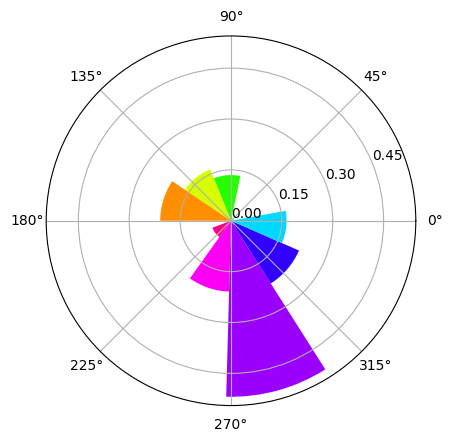

In [17]:
plot_latency_angle_hist(sd, good_pairs, by_firing_rate=True)

# Vector plots

In [7]:
plot_vector_layout

<function human_hip.spike_data.plot_latencies.plot_vector_layout(sd, pairs, normalize=True, arrow_length=75, min_dist=0, image_path=None, xlim=None, ylim=None, background_color='white')>

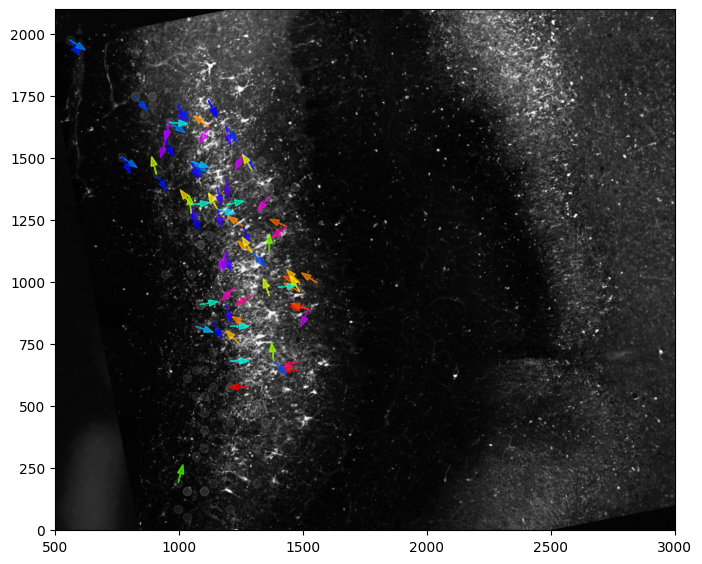

In [10]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc328_bw.jpeg", xlim=(500,3000) )

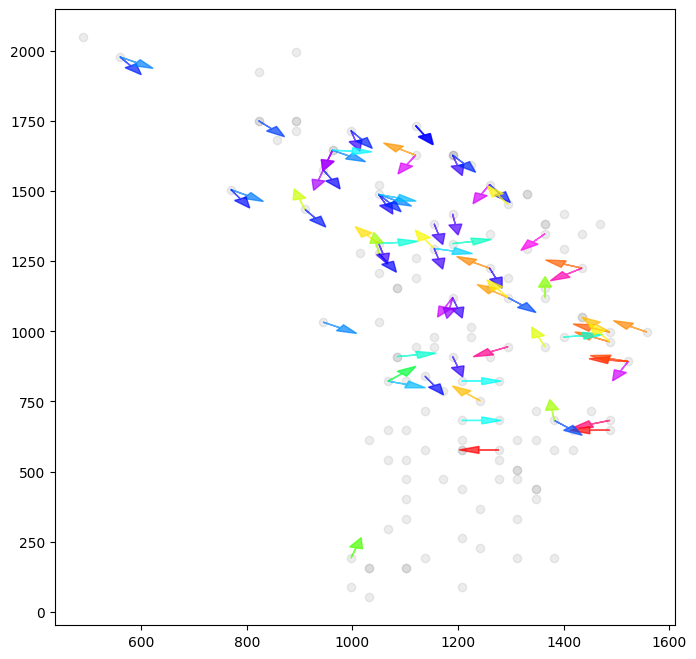

In [6]:
plot_vector_layout( sd, good_pairs)

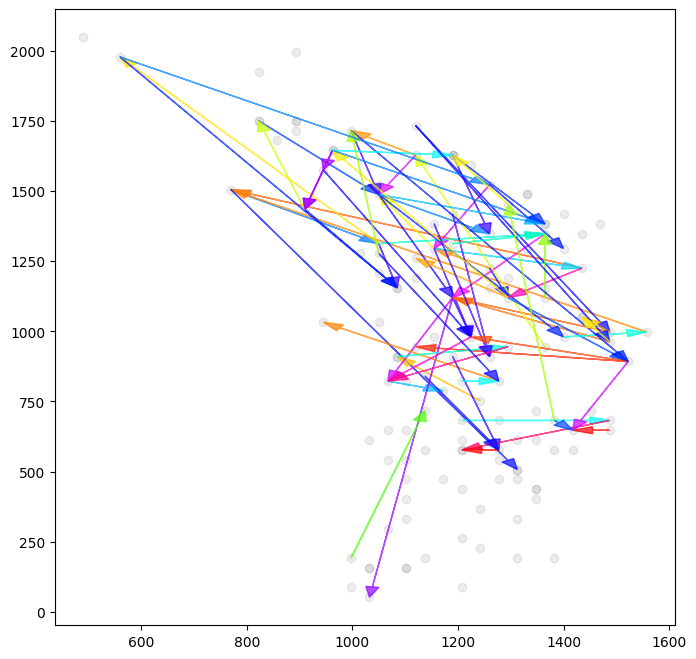

In [9]:
plot_vector_layout( sd, good_pairs, normalize=False)

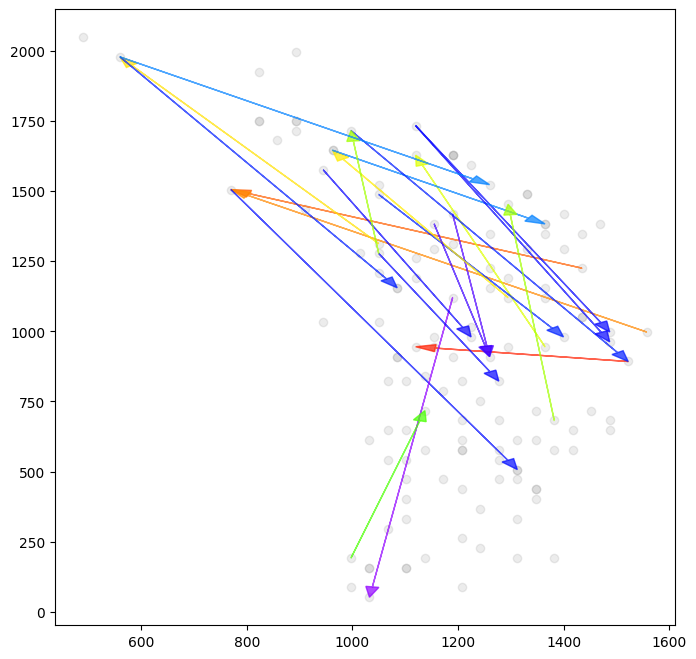

In [11]:
plot_vector_layout( sd, good_pairs, min_dist=400, normalize=False)

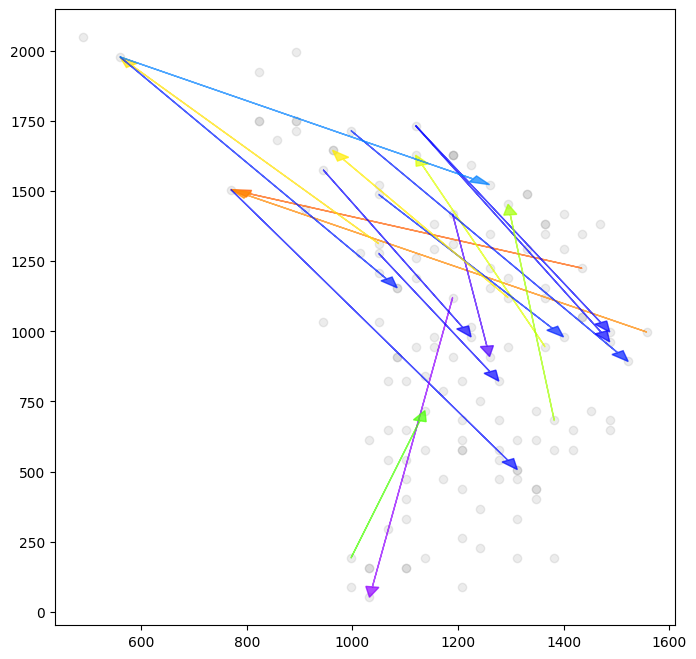

In [7]:
plot_vector_layout( sd, good_pairs, min_dist=500, normalize=False )

# Animations

2329 latency events occured in total spikedata
Making animation of 3.217 minutes
Saved animation to media/latencies.mp4


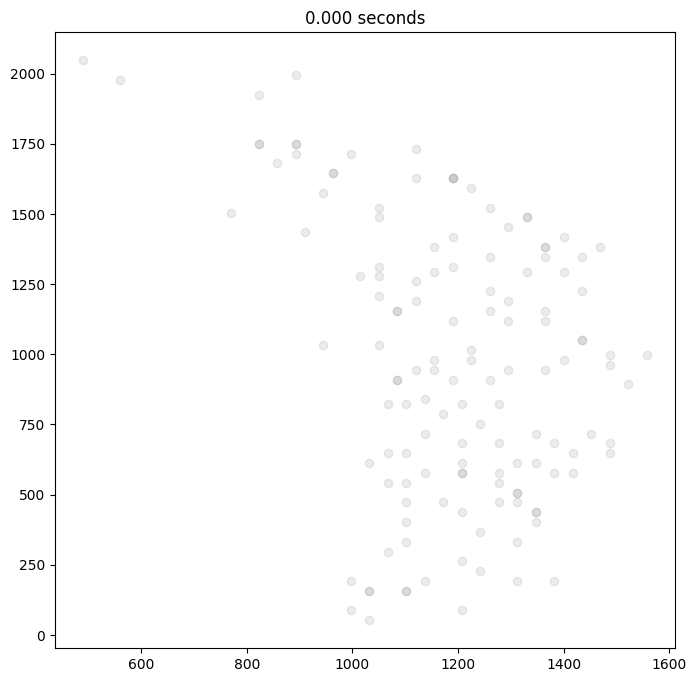

In [10]:
animate_latencies(sd, good_pairs, filename='media/latencies.mp4' )